In [1]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
input_file = "lending-club-data.csv"
loans = pd.read_csv(input_file, header = 0)

/Users/sarthakdasadia/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loans.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


Each loan is assigned a grade between `A` to `G`, along with a more finely discretized feature called `sub_grade` These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

In [7]:
loans['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

The target column (label column) of the dataset that I am interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, I reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

I put this in a new column called `safe_loans`.

In [8]:
loans['bad_loans'].head(5)

0    0
1    1
2    0
3    0
4    0
Name: bad_loans, dtype: int64

In [9]:
# bad_loans =  0 => safe
# bad_loans =  1 => risky
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)

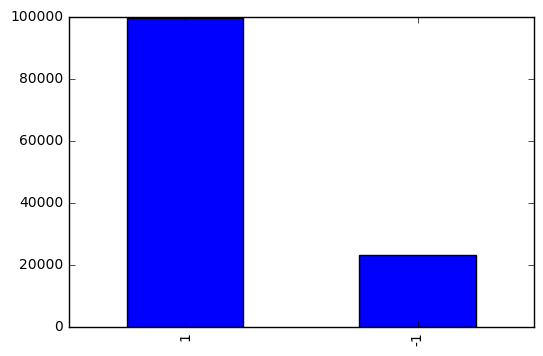

In [10]:
loans.safe_loans.value_counts().plot(kind='bar')

In [8]:
safe_loans_raw = loans[loans[ 'safe_loans'] == +1]
risky_loans_raw = loans[loans[ 'safe_loans'] == -1]
print "Number of safe loans  : %s" % len(safe_loans_raw)
print "Number of risky loans : %s" % len(risky_loans_raw)

Number of safe loans  : 99457
Number of risky loans : 23150


In [9]:
# Make equal number of safe and unsafe loans to train model

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage)

# Append the risky_loans with the downsampled version of safe_loans
loans_data = risky_loans_raw.append(safe_loans)

In [10]:
safe = loans_data[loans_data[ 'safe_loans'] == +1]
risky = loans_data[loans_data[ 'safe_loans'] == -1]
print "Number of safe loans  : %s" % len(safe)
print "Number of risky loans : %s" % len(risky)

Number of safe loans  : 23150
Number of risky loans : 23150


In [11]:
# Features to used in this analysis 

features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
           ]

target = 'safe_loans'                   # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans_data = loans_data[features + [target]]

In [12]:
loans_data.head(5)

,grade,sub_grade,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans
1,C,C4,1,1,RENT,1.00,car,60 months,1,1,9.4,0.0,-1
6,F,F2,0,5,OWN,5.55,small_business,60 months,1,1,32.6,0.0,-1
7,B,B5,1,1,RENT,18.08,other,60 months,1,1,36.5,0.0,-1
10,C,C1,1,1,RENT,10.08,debt_consolidation,36 months,1,1,91.7,0.0,-1
12,B,B2,0,4,RENT,7.06,other,36 months,1,1,55.5,0.0,-1


# 1. Decision Tree - Scikit-learn

In [13]:
# Training & Validation data

from sklearn.cross_validation import train_test_split
train_data, validation_data = train_test_split(loans_data, test_size = 0.2)

In [14]:
train_data.shape

(37040, 13)

In [15]:
validation_data.shape

(9260, 13)

In [16]:
# Convert data into numpy

def get_numpy_data(data_frame, features, label):
    features_array = np.array(data_frame[features])
    label_array = np.array(data_frame[label])
    return(features_array, label_array)


train_feature_matrix, train_target_matrix = get_numpy_data(train_data, features, target) 
validation_feature_matrix, validation_target_matrix = get_numpy_data(validation_data, features, target) 

In [17]:
print(train_feature_matrix[1:5,])
print(validation_feature_matrix[1:5])

[['E' 'E1' 1 1 'RENT' 1.09 'debt_consolidation' ' 36 months' 1 1 78.0 0.0]
 ['D' 'D1' 0 11 'MORTGAGE' 10.0 'other' ' 60 months' 1 1 46.4 0.0]
 ['C' 'C2' 0 11 'RENT' 33.6 'debt_consolidation' ' 36 months' 0 0 45.9 0.0]
 ['C' 'C4' 0 6 'OWN' 21.29 'debt_consolidation' ' 36 months' 1 1 89.0 0.0]]
[['C' 'C4' 0 11 'MORTGAGE' 20.33 'debt_consolidation' ' 36 months' 0 1 89.1
  14.9995]
 ['F' 'F2' 1 0 'MORTGAGE' 24.07 'debt_consolidation' ' 60 months' 1 1 93.9
  0.0]
 ['D' 'D4' 0 10 'RENT' 28.62 'other' ' 36 months' 0 0 67.8 0.0]
 ['A' 'A4' 0 5 'RENT' 13.1 'vacation' ' 36 months' 1 1 17.2 0.0]]


In [18]:
# Convert into incremental value
#http://stackoverflow.com/questions/30384995/randomforestclassfier-fit-valueerror-could-not-convert-string-to-float

from sklearn import preprocessing
#le = preprocessing.LabelEncoder()

l0e = preprocessing.LabelEncoder()
l0 = l0e.fit(train_feature_matrix[:,0])
train_feature_matrix[:,0]= l0.transform(train_feature_matrix[:,0])
validation_feature_matrix[:,0]= l0.transform(validation_feature_matrix[:,0])

l1e = preprocessing.LabelEncoder()
l1 = l1e.fit(train_feature_matrix[:,1])
train_feature_matrix[:,1]= l1.transform(train_feature_matrix[:,1])
validation_feature_matrix[:,1]= l1.transform(validation_feature_matrix[:,1])

l4e = preprocessing.LabelEncoder()
l4 = l4e.fit(train_feature_matrix[:,4])
train_feature_matrix[:,4]= l4.transform(train_feature_matrix[:,4])
validation_feature_matrix[:,4]= l4.transform(validation_feature_matrix[:,4])

l6e = preprocessing.LabelEncoder()
l6 = l6e.fit(train_feature_matrix[:,6])
train_feature_matrix[:,6]= l6.transform(train_feature_matrix[:,6])
validation_feature_matrix[:,6]= l6.transform(validation_feature_matrix[:,6])

l7e = preprocessing.LabelEncoder()
l7 = l7e.fit(train_feature_matrix[:,7])
train_feature_matrix[:,7]= l7.transform(train_feature_matrix[:,7])
validation_feature_matrix[:,7]= l7.transform(validation_feature_matrix[:,7])


In [19]:
print(train_feature_matrix[1:5,])
print(validation_feature_matrix[1:5,])

[[4 20 1 1 3 1.09 2 0 1 1 78.0 0.0]
 [3 15 0 11 0 10.0 8 1 1 1 46.4 0.0]
 [2 11 0 11 3 33.6 2 0 0 0 45.9 0.0]
 [2 13 0 6 2 21.29 2 0 1 1 89.0 0.0]]
[[2 13 0 11 0 20.33 2 0 0 1 89.1 14.9995]
 [5 26 1 0 0 24.07 2 1 1 1 93.9 0.0]
 [3 18 0 10 3 28.62 8 0 0 0 67.8 0.0]
 [0 3 0 5 3 13.1 10 0 1 1 17.2 0.0]]


In [20]:
train_target_matrix[1:10]

array([ 1,  1,  1,  1, -1,  1, -1, -1, -1])

In [21]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt = tree.DecisionTreeClassifier(max_depth=6)
clf = dt.fit(train_feature_matrix, train_target_matrix)

In [22]:
predicted = clf.predict(train_feature_matrix)

num_mistakes = (predicted != train_target_matrix).sum() 
num_correct = len(train_target_matrix) - num_mistakes
accuracy = num_correct/float(len(train_target_matrix)) 
print 'Accuracy on training data = %.2f' % accuracy

Accuracy on training data = 0.64


In [23]:
tree.export_graphviz(clf, out_file='tree.dot') 

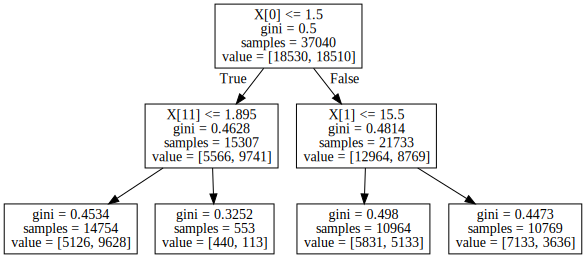

In [24]:
# Smaller Decision Tree

dt = tree.DecisionTreeClassifier(max_depth=2)
clf2 = dt.fit(train_feature_matrix, train_target_matrix)

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(clf2, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [25]:
predicted = clf.predict(validation_feature_matrix)

num_mistakes = (predicted != validation_target_matrix).sum() 
num_correct = len(validation_target_matrix) - num_mistakes
accuracy = num_correct/float(len(validation_target_matrix)) 
print 'Accuracy on validation data = %.2f' % accuracy

Accuracy on validation data = 0.63


In [26]:
dt = tree.DecisionTreeClassifier(max_depth=10)
clf3 = dt.fit(train_feature_matrix, train_target_matrix)

In [27]:
predicted = clf3.predict(validation_feature_matrix)

num_mistakes = (predicted != validation_target_matrix).sum() 
num_correct = len(validation_target_matrix) - num_mistakes
accuracy = num_correct/float(len(validation_target_matrix))
print 'Accuracy on validation data = %.2f' % accuracy

Accuracy on validation data = 0.63


### Model 2 with total number of trees = 6 is 63% accurate on validation dataset.

In [28]:
# ROC curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

predicted1 = clf.predict(validation_feature_matrix)
false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(validation_target_matrix, predicted1)
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)

predicted2 = clf2.predict(validation_feature_matrix)
false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(validation_target_matrix, predicted2)
roc_auc2 = auc(false_positive_rate2, true_positive_rate2)

predicted3 = clf3.predict(validation_feature_matrix)
false_positive_rate3, true_positive_rate3, thresholds3 = roc_curve(validation_target_matrix, predicted3)
roc_auc3 = auc(false_positive_rate3, true_positive_rate3)

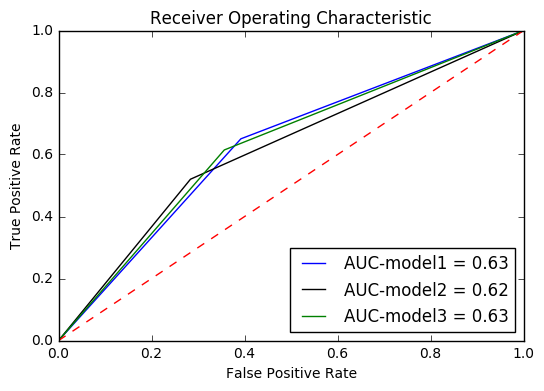

In [29]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1, 'b',label='AUC-model1 = %0.2f'% roc_auc1)
plt.plot(false_positive_rate2, true_positive_rate2, 'k',label='AUC-model2 = %0.2f'% roc_auc2)
plt.plot(false_positive_rate3, true_positive_rate3, 'g',label='AUC-model3 = %0.2f'% roc_auc3)
plt.plot([0,1],[0,1],'r--')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# 2. Ensamble Boosting

In [11]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [12]:
loans.shape

(122607, 69)

In [13]:
loans_data2 = loans[[target] + features].dropna() 

In [14]:
safe_loans_raw = loans_data2[loans_data2[target] == 1]
risky_loans_raw = loans_data2[loans_data2[target] == -1]

percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(frac = percentage)

# Append the risky_loans with the downsampled version of safe_loans
loans_data2 = risky_loans_raw.append(safe_loans)

In [15]:
safe_loans_raw = loans_data2[loans_data2[target] == 1]
risky_loans_raw = loans_data2[loans_data2[target] == -1]

In [16]:
len(risky_loans_raw)

23147

In [17]:
len(safe_loans_raw)

23147

In [18]:
from sklearn.cross_validation import train_test_split
train_data2, validation_data2 = train_test_split(loans_data2, test_size = 0.2)

In [19]:
def get_numpy_data(data_frame, features, label):
    features_array = np.array(data_frame[features])
    label_array = np.array(data_frame[label])
    return(features_array, label_array)


train_feature_matrix, train_target_matrix = get_numpy_data(train_data2, features, target) 
validation_feature_matrix, validation_target_matrix = get_numpy_data(validation_data2, features, target) 

In [20]:
train_feature_matrix[1:2]

array([['B', 1.0, 0, 4, 'RENT', 5.89, 'debt_consolidation', 3.09387, 1.0,
        0.0, 0.0, 0, 1, 10.0, 0.0, 1.0, 41.1, 0.0, 11.86, 624.25, 45000.0,
        3500, 3500, 116.02]], dtype=object)

In [21]:
from sklearn import preprocessing
#le = preprocessing.LabelEncoder()

l0e = preprocessing.LabelEncoder()
l0 = l0e.fit(train_feature_matrix[:,0])
train_feature_matrix[:,0]= l0.transform(train_feature_matrix[:,0])
validation_feature_matrix[:,0]= l0.transform(validation_feature_matrix[:,0])

l1e = preprocessing.LabelEncoder()
l1 = l1e.fit(train_feature_matrix[:,4])
train_feature_matrix[:,4]= l1.transform(train_feature_matrix[:,4])
validation_feature_matrix[:,4]= l1.transform(validation_feature_matrix[:,4])

l4e = preprocessing.LabelEncoder()
l4 = l4e.fit(train_feature_matrix[:,6])
train_feature_matrix[:,6]= l4.transform(train_feature_matrix[:,6])
validation_feature_matrix[:,6]= l4.transform(validation_feature_matrix[:,6])

In [22]:
train_feature_matrix[1:2]

array([[1, 1.0, 0, 4, 3, 5.89, 2, 3.09387, 1.0, 0.0, 0.0, 0, 1, 10.0, 0.0,
        1.0, 41.1, 0.0, 11.86, 624.25, 45000.0, 3500, 3500, 116.02]], dtype=object)

In [65]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

dt = GradientBoostingClassifier(n_estimators=200, max_depth=3)
clf4 = dt.fit(train_feature_matrix, train_target_matrix)

In [66]:
predicted = clf4.predict(validation_feature_matrix)

num_mistakes = (predicted != validation_target_matrix).sum() 
num_correct = len(validation_target_matrix) - num_mistakes
accuracy = num_correct/float(len(validation_target_matrix)) 
print 'Accuracy on validation data = %.2f' % accuracy

Accuracy on validation data = 0.68


In [31]:
def calculate_accuracy(predicted, true_label):
    num_mistakes = (predicted != true_label).sum()
    num_correct = len(true_label) - num_mistakes
    accuracy = num_correct/float(len(true_label)) 
    return(accuracy)

In [94]:
ntree = [10,50,100,200,300,400,500]
training_err = []
validation_err = []

for i in ntree:
    dt = GradientBoostingClassifier(n_estimators=i, max_depth=6)
    clf = dt.fit(train_feature_matrix, train_target_matrix)
    
    train_predict = clf.predict(train_feature_matrix)
    t_err = 1 - calculate_accuracy(train_predict,train_target_matrix)
    training_err.append(t_err)
    
    validation_predict = clf.predict(validation_feature_matrix)
    v_err = 1 - calculate_accuracy(validation_predict, validation_target_matrix) 
    validation_err.append(v_err)

In [95]:
import matplotlib.pyplot as plt
%matplotlib inline
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

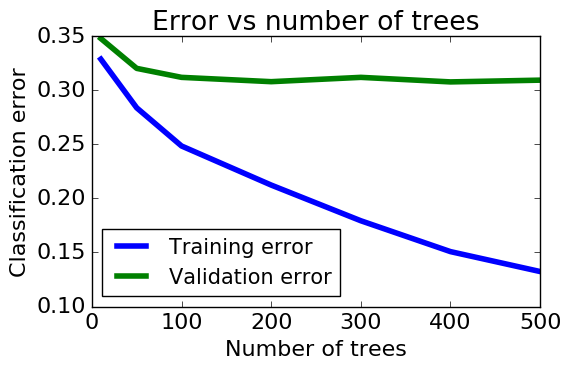

In [96]:
plt.plot([10,50,100,200,300,400,500], training_err, linewidth=4.0, label='Training error')
plt.plot([10,50,100,200,300,400,500], validation_err, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')

### Boosting method improved accuracy to ~70% and is quire robust to overfitting.

# 3. Random Forest

In [38]:
import sklearn
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100,n_jobs=4)
clf5 = rf.fit(train_feature_matrix, train_target_matrix)

In [39]:
predicted_rf = clf5.predict(validation_feature_matrix)
calculate_accuracy(predicted_rf,validation_target_matrix)

0.66994275839723516

In [40]:
importances = clf5.feature_importances_

In [44]:
importances
std = np.std([tree.feature_importances_ for tree in clf5.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
('int_rate', 0.10237845214730769)
('total_rec_int', 0.092788063285005884)
('payment_inc_ratio', 0.085150487211880219)
('revol_util', 0.080556131109546042)
('dti', 0.08023687478131393)
('annual_inc', 0.074363141007719347)
('installment', 0.069160486883128161)
('funded_amnt_inv', 0.059038955166323522)
('funded_amnt', 0.053451779215015885)
('open_acc', 0.052120990318402331)
('emp_length_num', 0.040895406943354543)
('grade', 0.038059646308819257)
('purpose', 0.029324770988632357)
('sub_grade_num', 0.027328911265380871)
('inq_last_6mths', 0.027283136478785011)
('total_rec_late_fee', 0.021153705452712633)
('home_ownership', 0.015959900910030078)
('last_delinq_none', 0.010602487379362121)
('delinq_2yrs', 0.0098182211428544438)
('last_major_derog_none', 0.007211131678543271)
('pub_rec', 0.0060726963773024504)
('delinq_2yrs_zero', 0.0060378138907533734)
('short_emp', 0.0056425233497432795)
('pub_rec_zero', 0.0053642867080834246)


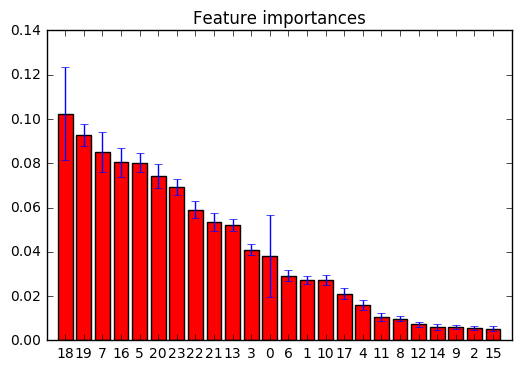

In [62]:
# Print the feature ranking
print("Feature ranking:")

for f in range(train_feature_matrix.shape[1]):
    print(features[indices[f]],importances[indices[f]])
    

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_feature_matrix.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_feature_matrix.shape[1]), indices)
plt.xlim([-1, train_feature_matrix.shape[1]])
plt.show()

## Interest rate, interest received to date, ratio of the monthly payment to income are some of the most important features to predict default loans.